In [3]:
!pip install kagglehub

In [4]:
import kagglehub, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [5]:
path = kagglehub.dataset_download("jacopoferretti/superstore-dataset")
print(path)

C:\Users\pablo\.cache\kagglehub\datasets\jacopoferretti\superstore-dataset\versions\1


In [3]:
df = pd.read_csv(os.path.join(path, "Sample - Superstore.csv"), encoding="latin1")
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## Análise de Vendas
### Convertendo as datas dos pedidos para datetime

In [4]:
df['Order Date Converted'] = pd.to_datetime(df['Order Date'], format='mixed')
print(df['Order Date Converted'])
df.info()

0      2016-11-08
1      2016-11-08
2      2016-06-12
3      2015-10-11
4      2015-10-11
          ...    
9989   2014-01-21
9990   2017-02-26
9991   2017-02-26
9992   2017-02-26
9993   2017-05-04
Name: Order Date Converted, Length: 9994, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Row ID                9994 non-null   int64         
 1   Order ID              9994 non-null   object        
 2   Order Date            9994 non-null   object        
 3   Ship Date             9994 non-null   object        
 4   Ship Mode             9994 non-null   object        
 5   Customer ID           9994 non-null   object        
 6   Customer Name         9994 non-null   object        
 7   Segment               9994 non-null   object        
 8   Country               9994 non-null   object  

## Análise de Vendas por Estado

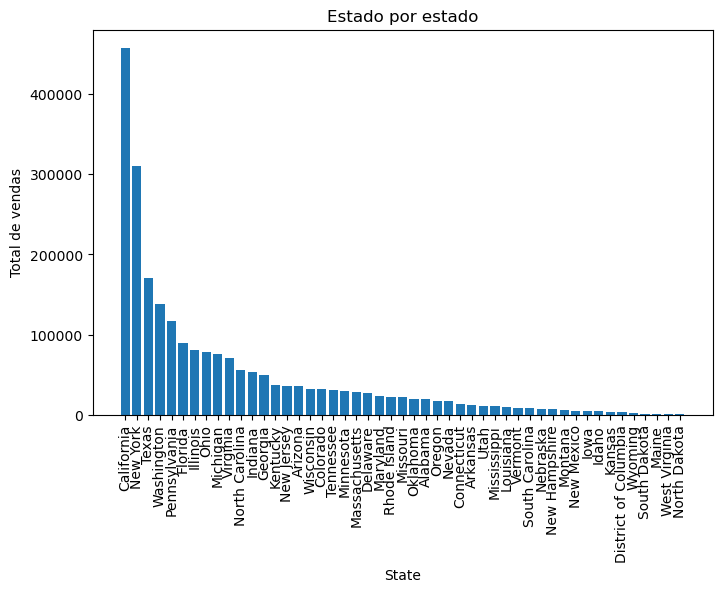

In [5]:
vendas_est = df.groupby('State')['Sales'].sum().reset_index()
vendas_est = vendas_est.sort_values(by='Sales', ascending=False) #Deixando em ordem crescente
plt.figure(figsize=(8, 5))
plt.bar(vendas_est['State'], vendas_est['Sales'])
plt.title('Estado por estado')
plt.xlabel('State')
plt.ylabel('Total de vendas')
plt.xticks(rotation=90)  # Rotate state names for better readability
plt.show()


Podemos observar que os estados com maior volume de vendas são:

📍 California

📍 New York

📍 Texas

Com base nessa informação, podemos focar em análises mais detalhadas sobre os padrões de compra e consequentemente nas estratégias de otimização de vendas.


Agora vamos identificar quais são as categorias mais vendidas nesses estados!!!

->Top 3 estados em vendas: ['California', 'New York', 'Texas']
        State         Category        Sales
0  California  Office Supplies  142351.9480
1  California        Furniture  156064.6015
2  California       Technology  159271.0820
3       Texas  Office Supplies   44490.5300
4       Texas        Furniture   60593.2918
5       Texas       Technology   65104.2240
6    New York  Office Supplies   90020.0420
7    New York        Furniture   93372.7290
8    New York       Technology  127483.5000


C:\Users\pablo\AppData\Local\Temp\ipykernel_19668\2270549511.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


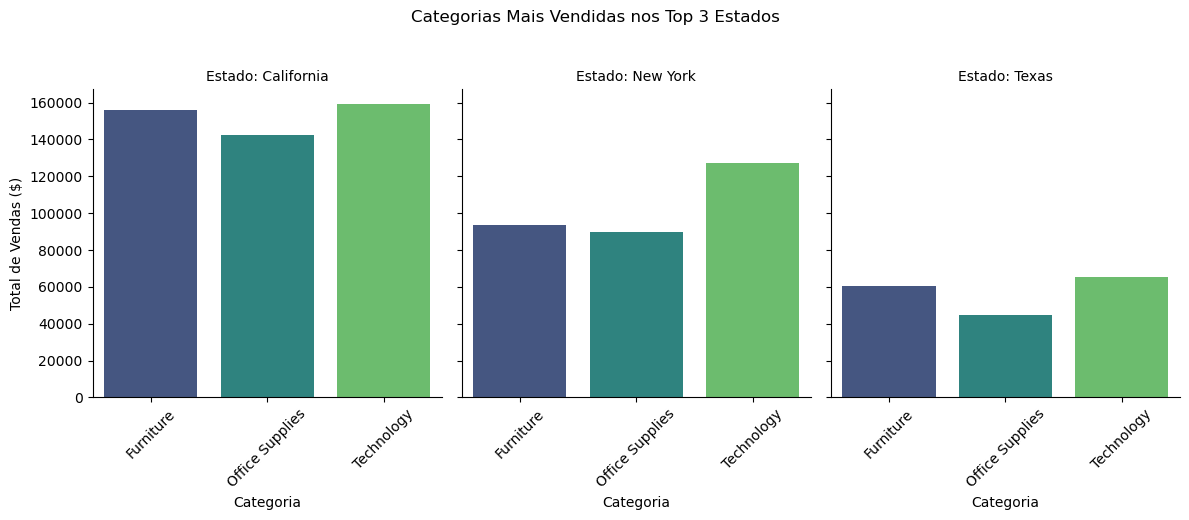

In [6]:
top_states = (
    df.groupby('State')['Sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)
print(f"->Top 3 estados em vendas: {top_states}")


df_top_states = df[df['State'].isin(top_states)]
#Agrupar por Estado e Categoria e somar as vendas
sales_by_cat = (
    df_top_states
    .groupby(['State', 'Category'])['Sales']
    .sum()
    .reset_index()
)
all_states = df_top_states['State'].unique()
all_categories = df_top_states['Category'].unique()
full_index = pd.MultiIndex.from_product([all_states, all_categories], names=['State', 'Category'])

sales_by_cat2 = (
    sales_by_cat
    .set_index(['State', 'Category'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)
print(sales_by_cat2)

g = sns.catplot(
    data=sales_by_cat,
    x='Category',
    y='Sales',
    col='State',
    kind='bar',
    height=5,
    aspect=0.8,
    palette='viridis'
)

g.fig.suptitle('Categorias Mais Vendidas nos Top 3 Estados', y=1.03)
g.set_axis_labels("Categoria", "Total de Vendas ($)")
g.set_titles("Estado: {col_name}")
g.set_xticklabels(rotation=45)

plt.tight_layout()
plt.show()


In [7]:
df['Day Week'] = df['Order Date Converted'].dt.dayofweek

df['Year'] = df['Order Date Converted'].dt.year
df['Month'] = df['Order Date Converted'].dt.month
df['Day'] = df['Order Date Converted'].dt.day




In [18]:
def train_model(df, estado=None, cat=None, n_est=100):
    if estado != None:
        df = df[df['State'] == estado]
    if cat != None:
        df = df[df['Category'] == cat]
    X = df[['Year', 'Month', 'Day', 'Day Week', 'Discount']]
    y = df['Sales']

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

    param_grid = {
    'n_estimators': [100, 200, 300],       # número de árvores
    'max_depth': [None, 10, 20, 30],       # profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],       # mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],         # mínimo de amostras por folha
    'max_features': ['auto', 'sqrt', 'log2'],  # número de atributos considerados em cada divisão
    'bootstrap': [True, False]             # se vai usar bootstrapping ou não
    }


    model = RandomForestRegressor(n_estimators=n_est, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='neg_mean_squared_error'  # ou 'r2', 'neg_mean_absolute_error'
    )
    grid_search.fit(X_train, y_train.ravel())

    y_pred_normalized = grid_search.predict(X_test)

    # Desnormalizando as previsões e os valores reais
    y_pred = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, 1))
    y_test = scaler_y.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse, X_test, y_test, y_pred

def plotar_resultados(y_test, y_pred, n_amostras=30):
    plt.figure(figsize=(10, 5))

     # Selecionando as primeiras n_amostras para o gráfico
    y_test_plot = y_test[:n_amostras]
    y_pred_plot = y_pred[:n_amostras]

    # Plotando os resultados
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_plot, label="Vendas Reais", marker='o')
    plt.plot(y_pred_plot, label="Vendas Previstas", linestyle="dashed", marker='s')
    plt.xlabel("Amostras")
    plt.ylabel("Vendas")
    plt.title("Vendas Reais vs. Vendas Previstas")
    plt.legend()
    plt.grid(True)
    plt.show()

### Analise de resultados do modelo para previsão englobando todos os estados

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
493 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\pablo\anaconda3\Lib\site-pack

<Figure size 1000x500 with 0 Axes>

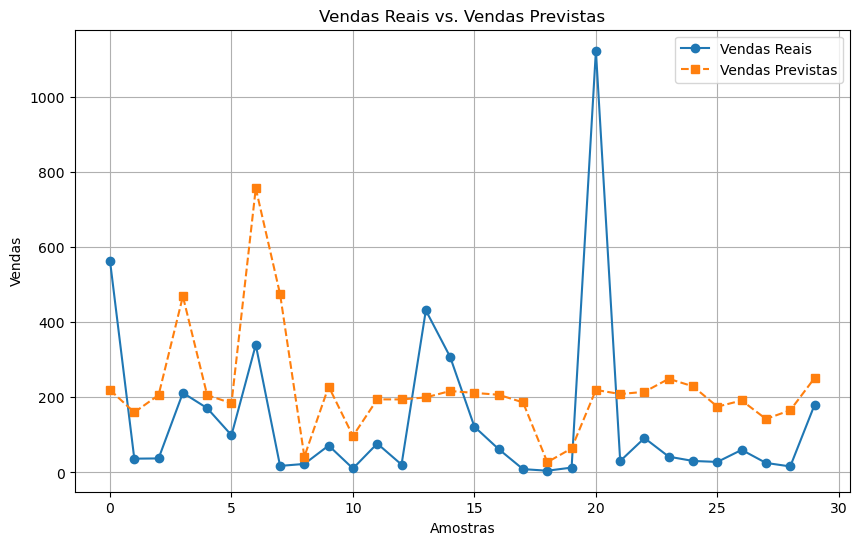

In [19]:
mae_geral, mse_geral, rmse_geral, X_test_geral, y_test_geral, y_pred_geral = train_model(df, n_est=100)
plotar_resultados(y_test_geral, y_pred_geral, n_amostras=30)

### Analise de resultados do modelo para previsão de vendas para o estado da California

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
896 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\pablo\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\pablo\anaconda3\Lib\site-pack

<Figure size 1000x500 with 0 Axes>

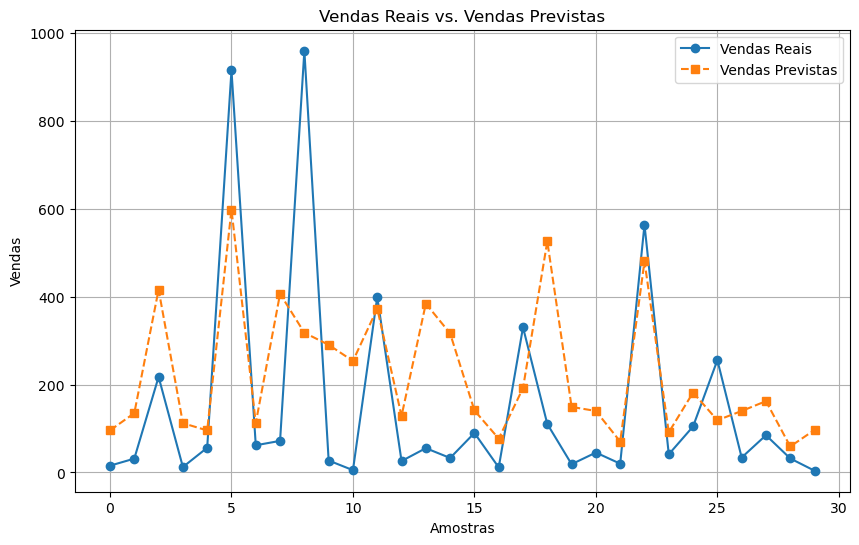

In [21]:
mae_geral_calif, mse_geral_calif, rmse_geral_calif, X_test_geral_calif, y_test_geral_calif, y_pred_geral_calif = train_model(df, estado="California",n_est=100)
plotar_resultados(y_test_geral_calif, y_pred_geral_calif)